In [1]:

%%capture
# This only runs in colab and clones the code sets it up and fixes a few issues, 
# you can skip this if you are running Jupyter Notebooks
import sys
if "google.colab" in sys.modules:
    branch = "0.4"    # change to the branch you want
    ! git clone --single-branch --branch $branch https://github.com/OpenMined/PySyft.git
    ! cd PySyft && ./scripts/colab.sh      # fixes some colab python issues
    sys.path.append("/content/PySyft/src") # prevents needing restart


this notebook is mainly based on [uid42](https://github.com/uid42)'s implementation on [#4901](https://github.com/OpenMined/PySyft/issues/4901). 

This notebook works in 0.4, but dosen't work in 0.3

In [2]:
import syft as sy
import sklearn
import torch
from sklearn.datasets import load_boston
from matplotlib import pyplot as plt

## Create a virtual machine

In [3]:
alice = sy.VirtualMachine()
alice_client = alice.get_root_client()

In [5]:
remote_torch = alice_client.torch

## Send data to alice

In [4]:
dataset = load_boston()
boston_data = torch.tensor(dataset["data"]).float()
boston_target = torch.tensor(dataset["target"]).float()

boston_data.tag("data")
boston_target.tag("target")

boston_data.send(alice_client, searchable =True)
boston_target.send(alice_client, searchable =True)

ds = [t for t in zip(boston_data, boston_target)]
ds = sy.lib.python.List(ds)
ds.tag("dataset")
ds.send(alice_client, searchable=True)

# check
alice_client.store.pandas

,ID,Tags,Description,object_type
0,<UID: 9124863512f74fe397d818093fe60cd5>,[data],,<class 'torch.Tensor'>
1,<UID: 7a808c896fc842a1b6f7e54f308a3b55>,[target],,<class 'torch.Tensor'>
2,<UID: bd3d678c954440ef8a56e4ca8554c937>,[dataset],,<class 'syft.lib.python.list.List'>


In [7]:
remote_dl = remote_torch.utils.data.DataLoader(
    alice_client.store[2], batch_size=32, shuffle=True
 )
# make the request to be approved automatically(#5015), or exception "Request to access data length not granted"
remote_dl.set_request_config({})

[2021-03-01T06:06:16.942929+0000][CRITICAL][logger] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 45ccfb1d082e4320bcfafe398715c076>.


In [8]:
class Model(sy.Module):
    def __init__(self, torch_ref):
        super(Model, self).__init__(torch_ref=torch_ref)   
        
        self.layer = self.torch_ref.nn.Linear(13, 1)

    def forward(self, x):
        output = self.layer(x)
        return output

local_model = Model(torch)
remote_model = local_model.send(alice_client)

In [9]:
loss_log = []
for epoch in range(2):
  epoch_loss = 0
  for i, t in enumerate(remote_dl):
      optimizer = remote_torch.optim.Adam(params=remote_model.parameters(),lr=1e-2)
      optimizer.zero_grad()    
      data, target = t[0], t[1]
      pred = remote_model(data)    
      loss = ((pred.view(-1) - target)**2).mean()
      loss.backward()
      optimizer.step()    
      gotloss = loss.get()
      print(f"[{epoch} - {i}], loss : {gotloss}")

      epoch_loss += gotloss
      
  loss_log.append(epoch_loss)

[2021-03-01T06:06:33.998068+0000][CRITICAL][logger] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3350f6e07f04441b91cd7d3fcdc6fa3b>.
/content/PySyft/src/syft/lib/torch/uppercase_tensor.py:45: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  grad = getattr(self.value, "grad", None)


[0 - 0], loss : 7569.056640625


[2021-03-01T06:06:34.754232+0000][CRITICAL][logger] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f6ca2ecc55104c0dacfef95022e19c95>.


[0 - 1], loss : 5609.076171875


[2021-03-01T06:06:35.188158+0000][CRITICAL][logger] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: bdc1394c57d14a40977dffea934d4e83>.


[0 - 2], loss : 5294.07568359375


[2021-03-01T06:06:35.628493+0000][CRITICAL][logger] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f29ace8a875146738cf5a6cb3687e7e3>.


[0 - 3], loss : 3337.662109375


[2021-03-01T06:06:36.069841+0000][CRITICAL][logger] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 549adbe2a0b349d2b78d8686e4146c45>.


[0 - 4], loss : 2681.205078125


[2021-03-01T06:06:36.502211+0000][CRITICAL][logger] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 31310020523f4afa9469dd59ba1ced58>.


[0 - 5], loss : 1902.0015869140625


[2021-03-01T06:06:36.952544+0000][CRITICAL][logger] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: daf71eb9274849718df6cddbd192ecf9>.


[0 - 6], loss : 1344.0174560546875


[2021-03-01T06:06:37.384832+0000][CRITICAL][logger] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f24f882dfc4f4040b0516287bf292202>.


[0 - 7], loss : 1171.1759033203125


[2021-03-01T06:06:37.829527+0000][CRITICAL][logger] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d08f786f1d9b48c48e0864b0d4f30504>.


[0 - 8], loss : 994.17919921875


[2021-03-01T06:06:38.267644+0000][CRITICAL][logger] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 63c92d2b42014810b15b7c1c6ae11108>.


[0 - 9], loss : 250.1975555419922


[2021-03-01T06:06:38.707269+0000][CRITICAL][logger] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 30828c8304234d6187935a8841cd851c>.


[0 - 10], loss : 329.06060791015625


[2021-03-01T06:06:39.136562+0000][CRITICAL][logger] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 713f61732c8147818f6c8113df3fc406>.


[0 - 11], loss : 174.1690216064453


[2021-03-01T06:06:39.561964+0000][CRITICAL][logger] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 57d393e29c404437bb81bfa7142d9ac2>.


[0 - 12], loss : 161.39324951171875


[2021-03-01T06:06:40.009602+0000][CRITICAL][logger] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0a254cc7a3c747ccafc2e05e4f9ddd8a>.


[0 - 13], loss : 307.6429748535156


[2021-03-01T06:06:40.440220+0000][CRITICAL][logger] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b08fb749d7104d1f82805d9d2ffc6c98>.


[0 - 14], loss : 185.72035217285156


[2021-03-01T06:06:40.906921+0000][CRITICAL][logger] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 988d7a0c09f64d54955d266be895cdf1>.
[2021-03-01T06:06:41.145176+0000][CRITICAL][logger] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 28d16d2f400d4e27b7fd2c9db40f28d8>.


[0 - 15], loss : 147.42662048339844


[2021-03-01T06:06:41.377938+0000][CRITICAL][logger] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 74ebdb931da94690bc0e49980226c197>.


[1 - 0], loss : 231.244873046875


[2021-03-01T06:06:41.811829+0000][CRITICAL][logger] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: eed463612fd04da3bba13727ea20003d>.


[1 - 1], loss : 119.6408462524414


[2021-03-01T06:06:42.255695+0000][CRITICAL][logger] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6558e9f202d6421f868fe4972cb1f87f>.


[1 - 2], loss : 158.04197692871094


[2021-03-01T06:06:42.700285+0000][CRITICAL][logger] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c4154ff3188e4b0f99fcb59d222ad26c>.


[1 - 3], loss : 277.56414794921875


[2021-03-01T06:06:43.139562+0000][CRITICAL][logger] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 361546ec013f4baa88b99720d35b0d05>.


[1 - 4], loss : 109.14098358154297


[2021-03-01T06:06:43.579621+0000][CRITICAL][logger] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c05ff267dc6a4b68b824b3e45e1ea946>.


[1 - 5], loss : 226.4268798828125


[2021-03-01T06:06:44.023405+0000][CRITICAL][logger] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: cf872673f77e4c9ba6f0f23637d2f23c>.


[1 - 6], loss : 89.37860107421875


[2021-03-01T06:06:44.474927+0000][CRITICAL][logger] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c19de5f7484347c085071f8aa2f47db6>.


[1 - 7], loss : 174.861328125


[2021-03-01T06:06:44.925344+0000][CRITICAL][logger] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b77b6626f19c426e81e7ddf3857816d5>.


[1 - 8], loss : 168.7006378173828


[2021-03-01T06:06:45.356965+0000][CRITICAL][logger] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f6c96ca65e194ae3a9baeff7c4063de0>.


[1 - 9], loss : 132.24166870117188


[2021-03-01T06:06:45.785381+0000][CRITICAL][logger] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ae709fcd5ddc4abe932cc0d250575300>.


[1 - 10], loss : 114.78844451904297


[2021-03-01T06:06:46.224625+0000][CRITICAL][logger] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c1fd5e7078254ecbb96167fa6e9b469a>.


[1 - 11], loss : 109.70777130126953


[2021-03-01T06:06:46.671803+0000][CRITICAL][logger] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3571c829bc5a4ad793ff95a01924ce9e>.


[1 - 12], loss : 235.74343872070312


[2021-03-01T06:06:47.111895+0000][CRITICAL][logger] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b95f518ac0b04fd1994d8a944dfeaddf>.


[1 - 13], loss : 127.6319580078125


[2021-03-01T06:06:47.538715+0000][CRITICAL][logger] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 71e80f265fa646d4bee6a48c0dd34891>.


[1 - 14], loss : 103.74922180175781


[2021-03-01T06:06:47.975432+0000][CRITICAL][logger] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b524c8852a594dc8b2553df2386930c9>.


[1 - 15], loss : 89.54304504394531


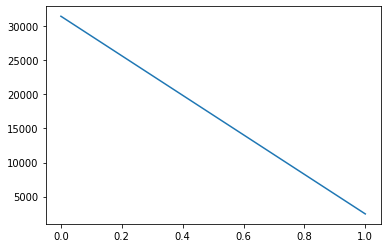

In [10]:
plt.plot(loss_log)

In [11]:
remote_model.get().save(f"final_model.pt")
local_model = remote_model.get()

local_loss = 0
with torch.no_grad():
  for i, t in enumerate(remote_dl): 
      data, target = t[0], t[1]
      pred = remote_model(data)    
      loss = ((pred.view(-1) - target)**2).mean() 
      gotloss = loss.get()
      local_loss += gotloss

print(f"loss on local model is {local_loss}")

[2021-03-01T06:09:04.174719+0000][CRITICAL][logger] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c55730ddf2434118abc6a6b11d7e0a08>.
[2021-03-01T06:09:04.284966+0000][CRITICAL][logger] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0fbac44acaf74cc1bcc4e3225ccd8414>.
[2021-03-01T06:09:04.292832+0000][CRITICAL][logger] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 72f3e16df9e54d8db2169f9191450b5e>.
[2021-03-01T06:09:04.535624+0000][CRITICAL][logger] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7642520267394cf18547e9503c7fae08>.
[2021-03-01T06:09:04.807487+0000][CRITICAL][logger] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c7d336fa773d495581ae68803f1f6224>.
[2021-03-01T06:09:05.113158+0000][CRITICAL][logger] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 69450410d73149f3afeb2e6851b2eb17>.
[2021-03-01T06:09:05.385709+

loss on local model is 1628.5972900390625
